In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, datasets
from PIL import Image
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Define paths
base_path = '/content/drive/MyDrive/MPI data/newww_dataset'

classes = {
    "Infarction": {"rest": "Infarction/rest", "stress": "Infarction/stress"},
    "Ischemia": {"rest": "Ischemia/rest", "stress": "Ischemia/stress"},
    "Normal": {"rest": "Normal/rest", "stress": "Normal/stress"}
}


In [6]:
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
class MPIDataset(Dataset):
    def __init__(self, base_path, classes, transform=None):
        self.base_path = base_path
        self.transform = transform
        self.classes = classes
        self.data = []
        self.labels = []

        # Mapping for labels
        self.label_map = {'Infarction': 0, 'Ischemia': 1, 'Normal': 2}

        # Verify base path
        print(f"Checking base path: {base_path}")
        if not os.path.exists(base_path):
            raise ValueError(f"Base path does not exist: {base_path}")

        # Load data directly from folders
        for class_name, paths in classes.items():
            rest_path = os.path.join(base_path, paths['rest'])
            stress_path = os.path.join(base_path, paths['stress'])

            print(f"Checking Rest path for {class_name}: {rest_path}")
            print(f"Checking Stress path for {class_name}: {stress_path}")

            if not os.path.exists(rest_path) or not os.path.exists(stress_path):
                print(f"Error: One or both paths do not exist - Rest: {rest_path}, Stress: {stress_path}")
                continue

            # Load rest images
            rest_files = [f for f in os.listdir(rest_path) if f.lower().endswith(('.jpg', '.jpeg'))]
            rest_patient_dict = {}
            for rest_file in rest_files:
                try:
                    filename = os.path.basename(rest_file)
                    patient_id = filename.split('_')[0].replace('patient', '')
                    if patient_id.isdigit():
                        rest_patient_dict.setdefault(patient_id, []).append(os.path.join(rest_path, rest_file))
                    else:
                        print(f"Warning: Invalid patient ID in Rest: {filename}")
                except (IndexError, ValueError):
                    print(f"Warning: Skipping invalid filename format in Rest: {filename}")

            # Load stress images
            stress_files = [f for f in os.listdir(stress_path) if f.lower().endswith(('.jpg', '.jpeg'))]
            stress_patient_dict = {}
            for stress_file in stress_files:
                try:
                    filename = os.path.basename(stress_file)
                    patient_id = filename.split('_')[0].replace('patient', '')
                    if patient_id.isdigit():
                        stress_patient_dict.setdefault(patient_id, []).append(os.path.join(stress_path, stress_file))
                    else:
                        print(f"Warning: Invalid patient ID in Stress: {filename}")
                except (IndexError, ValueError):
                    print(f"Warning: Skipping invalid filename format in Stress: {filename}")

            # Print individual image counts
            print(f"Class {class_name}: {len(rest_files)} Rest images, {len(stress_files)} Stress images")

            # Match pairs
            total_pairs = 0
            common_patients = set(rest_patient_dict.keys()) & set(stress_patient_dict.keys())
            for patient_id in common_patients:
                if rest_patient_dict[patient_id] and stress_patient_dict[patient_id]:
                    rest_full_path = rest_patient_dict[patient_id][0]
                    stress_full_path = stress_patient_dict[patient_id][0]
                    self.data.append((rest_full_path, stress_full_path))
                    self.labels.append(self.label_map[class_name])
                    total_pairs += 1

            print(f"Class {class_name}: Loaded {total_pairs} pairs from {len(common_patients)} common patients")

        if not self.data:
            raise ValueError("No valid image pairs found. Check file paths, naming conventions, or ensure matching patient IDs in Rest and Stress folders.")

        # Print total class distribution (pairs)
        from collections import Counter
        label_counts = Counter(self.labels)
        print("Class distribution (pairs):", label_counts)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        rest_path, stress_path = self.data[idx]
        label = self.labels[idx]

        rest_img = Image.open(rest_path).convert('RGB')
        stress_img = Image.open(stress_path).convert('RGB')

        if self.transform:
            rest_img = self.transform(rest_img)
            stress_img = self.transform(stress_img)

        return rest_img, stress_img, label

# Test the dataset loading
try:
    full_dataset = MPIDataset(base_path, classes, transform=None)
    print(f"Successfully loaded dataset with {len(full_dataset)} pairs")
except Exception as e:
    print(f"Error loading dataset: {str(e)}")

Checking base path: /content/drive/MyDrive/MPI data/newww_dataset
Checking Rest path for Infarction: /content/drive/MyDrive/MPI data/newww_dataset/Infarction/rest
Checking Stress path for Infarction: /content/drive/MyDrive/MPI data/newww_dataset/Infarction/stress
Class Infarction: 390 Rest images, 390 Stress images
Class Infarction: Loaded 390 pairs from 390 common patients
Checking Rest path for Ischemia: /content/drive/MyDrive/MPI data/newww_dataset/Ischemia/rest
Checking Stress path for Ischemia: /content/drive/MyDrive/MPI data/newww_dataset/Ischemia/stress
Class Ischemia: 390 Rest images, 390 Stress images
Class Ischemia: Loaded 390 pairs from 390 common patients
Checking Rest path for Normal: /content/drive/MyDrive/MPI data/newww_dataset/Normal/rest
Checking Stress path for Normal: /content/drive/MyDrive/MPI data/newww_dataset/Normal/stress
Class Normal: 390 Rest images, 390 Stress images
Class Normal: Loaded 390 pairs from 390 common patients
Class distribution (pairs): Counter({

In [8]:



# Load datasets
full_dataset = MPIDataset(base_path, classes, transform=train_transform)

Checking base path: /content/drive/MyDrive/MPI data/newww_dataset
Checking Rest path for Infarction: /content/drive/MyDrive/MPI data/newww_dataset/Infarction/rest
Checking Stress path for Infarction: /content/drive/MyDrive/MPI data/newww_dataset/Infarction/stress
Class Infarction: 390 Rest images, 390 Stress images
Class Infarction: Loaded 390 pairs from 390 common patients
Checking Rest path for Ischemia: /content/drive/MyDrive/MPI data/newww_dataset/Ischemia/rest
Checking Stress path for Ischemia: /content/drive/MyDrive/MPI data/newww_dataset/Ischemia/stress
Class Ischemia: 390 Rest images, 390 Stress images
Class Ischemia: Loaded 390 pairs from 390 common patients
Checking Rest path for Normal: /content/drive/MyDrive/MPI data/newww_dataset/Normal/rest
Checking Stress path for Normal: /content/drive/MyDrive/MPI data/newww_dataset/Normal/stress
Class Normal: 390 Rest images, 390 Stress images
Class Normal: Loaded 390 pairs from 390 common patients
Class distribution (pairs): Counter({

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter

# Stratified Split
labels = np.array(full_dataset.labels)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, val_test_idx = next(splitter.split(labels, labels))
val_test_labels = labels[val_test_idx]
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(splitter.split(val_test_labels, val_test_labels))

train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
val_dataset = torch.utils.data.Subset(full_dataset, val_test_idx[val_idx])
test_dataset = torch.utils.data.Subset(full_dataset, val_test_idx[test_idx])

val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

# Print class distribution
label_counts = Counter(full_dataset.labels)
print("Class distribution:", label_counts)

# Define the device here, before it is used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Add class weights to criterion
total_samples = sum(label_counts.values())
class_weights = torch.tensor([total_samples / (len(label_counts) * count) for count in label_counts.values()]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

Class distribution: Counter({0: 390, 1: 390, 2: 390})


In [10]:
# Define the ResNet18 model with shared weights
class DualBranchResNet18(nn.Module):
    def __init__(self, num_classes=3):
        super(DualBranchResNet18, self).__init__()
        # Load pre-trained ResNet18
        self.base_model = models.resnet18(pretrained=True)

        # Freeze base layers
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove the final fully connected layer
        self.base_model.fc = nn.Identity()

        # Define the head for combined features
        self.head = nn.Sequential(
            nn.Linear(512 * 2, 512),  # 512 from each branch
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, rest_input, stress_input):
        # Extract features from both branches
        rest_features = self.base_model(rest_input)
        stress_features = self.base_model(stress_input)

        # Concatenate features
        combined = torch.cat((rest_features, stress_features), dim=1)

        # Pass through the head
        output = self.head(combined)
        return output

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DualBranchResNet18(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# Training loop
num_epochs = 25
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (rest_imgs, stress_imgs, labels) in enumerate(train_loader):
        rest_imgs, stress_imgs, labels = rest_imgs.to(device), stress_imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(rest_imgs, stress_imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 10 == 0:  # Print every 10 batches
            print(f"Epoch {epoch+1}, Batch {i}, Loss: {loss.item():.4f}")
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for rest_imgs, stress_imgs, labels in val_loader:
            rest_imgs, stress_imgs, labels = rest_imgs.to(device), stress_imgs.to(device), labels.to(device)
            outputs = model(rest_imgs, stress_imgs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print results for both train and validation
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Epoch 1, Batch 0, Loss: 1.1085
Epoch 1, Batch 10, Loss: 1.0977
Epoch 1, Batch 20, Loss: 1.0678
Epoch [1/25], Train Loss: 1.0887, Train Acc: 38.83%, Val Loss: 1.0646, Val Acc: 54.86%
Epoch 2, Batch 0, Loss: 1.0664
Epoch 2, Batch 10, Loss: 1.0649
Epoch 2, Batch 20, Loss: 1.0498
Epoch [2/25], Train Loss: 1.0571, Train Acc: 46.52%, Val Loss: 1.0292, Val Acc: 75.43%
Epoch 3, Batch 0, Loss: 1.0627
Epoch 3, Batch 10, Loss: 1.0437
Epoch 3, Batch 20, Loss: 1.0447
Epoch [3/25], Train Loss: 1.0267, Train Acc: 55.07%, Val Loss: 0.9903, Val Acc: 81.71%
Epoch 4, Batch 0, Loss: 0.9707
Epoch 4, Batch 10, Loss: 1.0196
Epoch 4, Batch 20, Loss: 0.9843
Epoch [4/25], Train Loss: 0.9878, Train Acc: 64.96%, Val Loss: 0.9502, Val Acc: 84.00%
Epoch 5, Batch 0, Loss: 0.9440
Epoch 5, Batch 10, Loss: 0.9930
Epoch 5, Batch 20, Loss: 0.9314
Epoch [5/25], Train Loss: 0.9624, Train Acc: 66.54%, Val Loss: 0.9072, Val Acc: 85.71%
Epoch 6, Batch 0, Loss: 0.9360
Epoch 6, Batch 10, Loss: 0.8972
Epoch 6, Batch 20, Loss: 0.

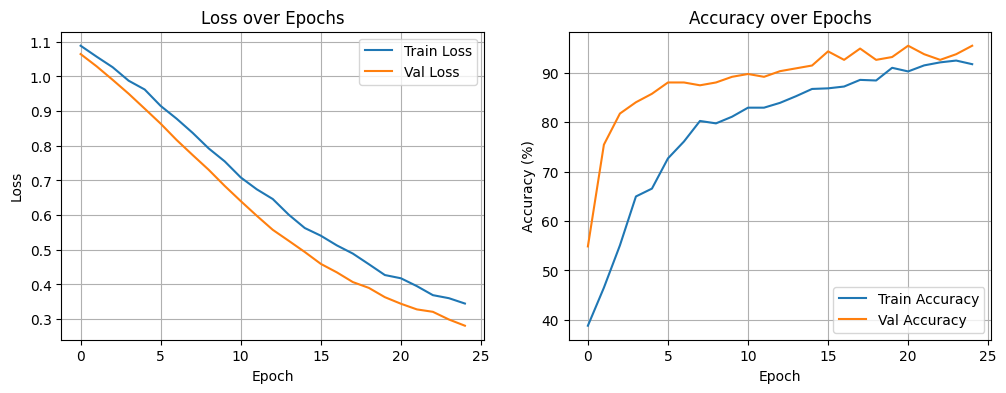

In [12]:
# Plot training and validation metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Ensure DataLoader is optimized
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Evaluate on test set and compute accuracy
model.eval()
y_true, y_pred = [], []
correct = 0
total = 0

with torch.no_grad():
    for i, (rest_imgs, stress_imgs, labels) in enumerate(test_loader):
        rest_imgs, stress_imgs, labels = rest_imgs.to(device), stress_imgs.to(device), labels.to(device)
        outputs = model(rest_imgs, stress_imgs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 10 == 0:  # Print every 10 batches
            print(f"Processed batch {i}")

# Calculate and print test accuracy
test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

Processed batch 0
Test Accuracy: 92.61%


F1 Score: 0.9253
Recall Score: 0.9261
Precision Score: 0.9310


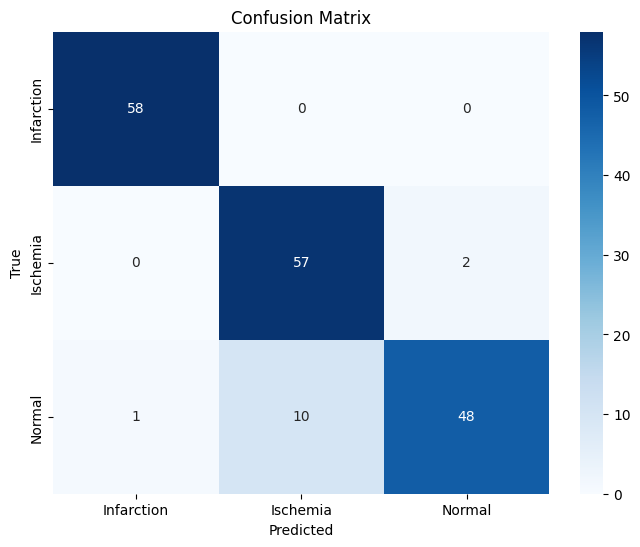

In [14]:
# Calculate metrics
f1 = f1_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')

print(f"F1 Score: {f1:.4f}")
print(f"Recall Score: {recall:.4f}")
print(f"Precision Score: {precision:.4f}")

# Confusion matrix
from sklearn.metrics import confusion_matrix # Import confusion_matrix here
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Infarction', 'Ischemia', 'Normal'], yticklabels=['Infarction', 'Ischemia', 'Normal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()